<a href="https://colab.research.google.com/github/matt1209/Pytorch-case-study/blob/master/fastai/pets_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !curl -s https://course.fast.ai/setup/colab | bash

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64

In [3]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_177.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_179.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/samoyed_89.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_179.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_108.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

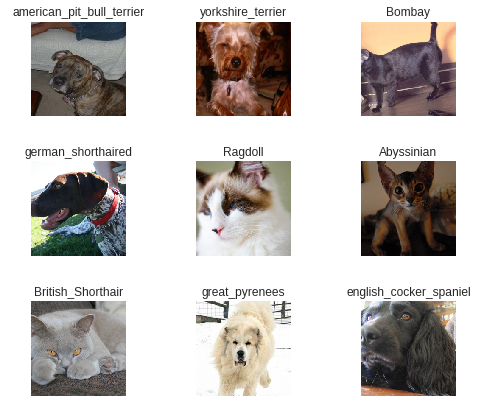

In [9]:
data.show_batch(rows=3, figsize=(7,6))

In [10]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [11]:
len(data.classes), data.c

(37, 37)

### Training: resnet34

In [12]:
help(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data:fastai.basic_data.DataBunch, base_arch:Callable, cut:Union[int, Callable]=None, pretrained:bool=True, lin_ftrs:Union[Collection[int], NoneType]=None, ps:Union[float, Collection[float]]=0.5, custom_head:Union[torch.nn.modules.module.Module, NoneType]=None, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, bn_final:bool=False, init=<function kaiming_normal_ at 0x7fa86b0f9400>, concat_pool:bool=True, **kwargs:Any) -> fastai.basic_train.Learner
    Build convnet style learner.



In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 85868829.55it/s]


In [0]:
learn.model

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.400460,0.319797,0.094723,01:56
1,0.562306,0.256825,0.088633,01:56
2,0.347856,0.208299,0.074425,01:55
3,0.261722,0.198282,0.069012,01:57


In [0]:
learn.save('stage-1')

### Results

In [0]:
interpretation = ClassificationInterpretation.from_learner(learn)

In [19]:
losses, idxs = interpretation.top_losses()
print(losses)
print(idxs)

tensor([8.0264e+00, 4.6091e+00, 4.4902e+00,  ..., 3.8147e-06, 1.9073e-06,
        1.9073e-06])
tensor([1218,  269, 1463,  ..., 1018, 1421, 1321])


In [20]:
len(data.valid_ds) == len(losses) == len(idxs)

True

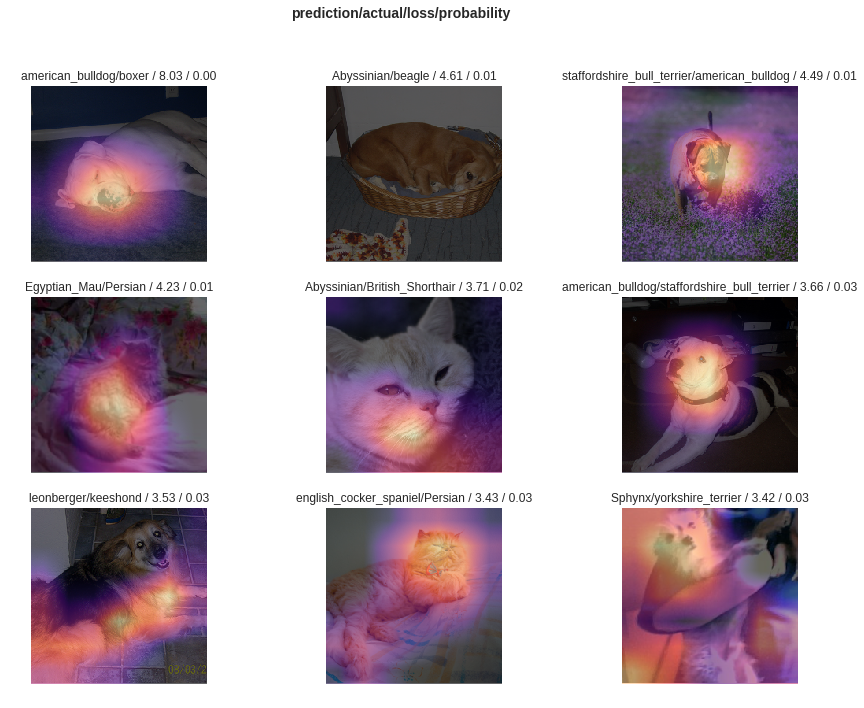

In [21]:
interpretation.plot_top_losses(9, figsize=(15,11))

In [22]:
doc(interpretation.plot_top_losses)

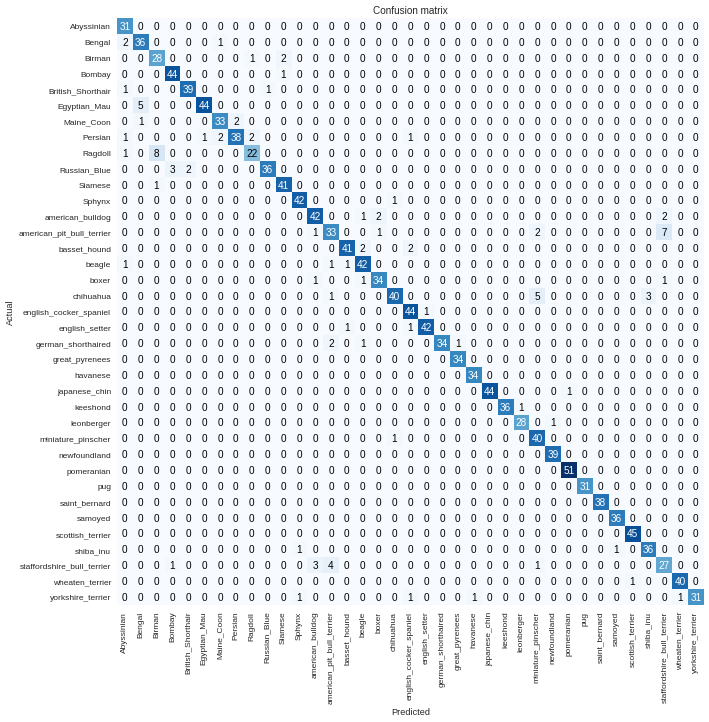

In [23]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
interpretation.most_confused(min_val=2)

[('Ragdoll', 'Birman', 8),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Russian_Blue', 'Bombay', 3),
 ('chihuahua', 'shiba_inu', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Birman', 'Siamese', 2),
 ('Maine_Coon', 'Persian', 2),
 ('Persian', 'Maine_Coon', 2),
 ('Persian', 'Ragdoll', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('basset_hound', 'beagle', 2),
 ('basset_hound', 'english_cocker_spaniel', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2)]

###Unfreezing, fine-tuning, and learning rates

In [0]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.514683,0.277438,0.090663,02:00


In [27]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wheaten_terrier,Siamese,samoyed,wheaten_terrier,japanese_chin
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
basset_hound,english_setter,yorkshire_terrier,Birman,boxer
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stri

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


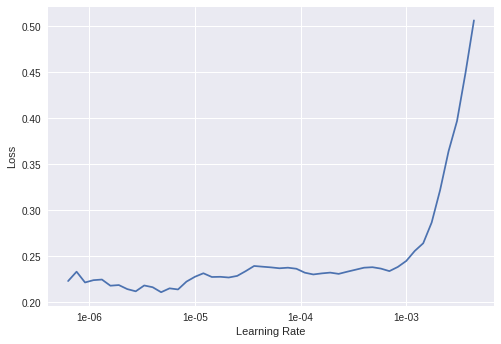

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.218148,0.187734,0.062923,02:00
1,0.208108,0.181483,0.063599,02:01


### Training: resnet50

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [32]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 93509811.48it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


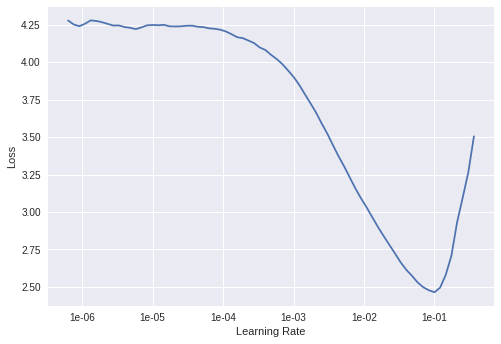

In [33]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.713290,0.264282,0.077131,03:30
1,0.447739,0.248106,0.080514,03:23


In [0]:
learn.save('stage-1-50')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

### Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
print(labels[:5])
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes